# Imports

In [1]:
# Import all libraries
import requests
from tqdm import trange
import zipfile
import os
from PIL import Image
import numpy as np
import pylab as plt
import matplotlib
from random import randint
from scipy.ndimage.interpolation import rotate
from skimage.transform import rescale, resize
from IPython.display import clear_output
import random
import shutil
import pandas as pd
import cv2
import time

%matplotlib inline

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization
from keras import optimizers, regularizers
from keras.optimizers import SGD, Adam
import keras.callbacks
from keras import backend as K

import h5py
from keras.utils.np_utils import to_categorical



from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score

from create_model import createResNet50, CreateKaggleModel, createResNet50Top

import stainNorm_Reinhard as stainNorm


# this part is needed if you run the notebook on Cartesius with multiple cores
#n_cores = 32
#config = tf.ConfigProto(intra_op_parallelism_threads=n_cores-1, inter_op_parallelism_threads=1, allow_soft_placement=True)
#session = tf.Session(config=config)
#K.set_session(session)
#os.environ["OMP_NUM_THREADS"] = str(n_cores-1)
#os.environ["KMP_BLOCKTIME"] = "1"
#os.environ["KMP_SETTINGS"] = "1"
#os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape = [2,3], name = 'a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape = [3,2], name = 'b')
c = tf.matmul(a, b)

sess = tf.Session(config=tf.ConfigProto(log_device_placement = True))
print(sess.run(c))



Using TensorFlow backend.


[[22. 28.]
 [49. 64.]]


# Classes

In [2]:
class DataSet:
    
    def __init__(self, data_dir_x, data_dir_y = None, use_percentage = 1.0):
        self.use_percentage = use_percentage
        self.data_dir_x = data_dir_x
        self.data_dir_y = data_dir_y
    
    def get_lenght(self):
        with h5py.File(self.data_dir_x, 'r') as hdf:
            return (int)(len(hdf['x'])*self.use_percentage)
    
    def get_data(self):
        with h5py.File(self.data_dir_x, 'r') as hdf:
            return np.array( list(hdf['x']))/255
        
    def get_lbls(self):
        with h5py.File(self.data_dir_y, 'r') as hdf:
            data = list(hdf['y'])
            return np.reshape(data,(len(data))) 
        
    
    def show_image(self, i):
        with h5py.File(self.data_dir_x, 'r') as hdf:
            data = list(hdf['x'][i])
            img = np.array(data)
            plt.rcParams['figure.figsize'] = (3, 3)
            plt.imshow(img)
            plt.title('RGB image')
            plt.show()

In [3]:
class Augmentor:
    def __init__(self, perc =.5):
        self.perc = perc
        
    def rotate(self, image):
        #rotation of 0-360
        rows,cols,channels = image.shape
        deg = np.random.randint(360)
        M = cv2.getRotationMatrix2D((cols/2,rows/2),deg,1)
        image = cv2.warpAffine(image,M,(cols,rows))
        return image
    
    def fliphorizontal(self, image):
        #horizontal flip
        image = cv2.flip(image, 0)
        return image
    
    def flipvertical(self, image):
        #vertical flip
        image = cv2.flip(image, 1)
        return image
    
    def flipboth(self, image):
        image = cv2.flip(image, -1)
        return image

In [4]:
class BatchCreator:
    
    def __init__(self, dataset, augmentor = None, learned_dataset = None, not_learned_dataset = None, l_per = None):
        self.dataset = dataset
        self.dataset_length = self.dataset.get_lenght()
        self.augmentor = augmentor
        
        self.learned_dataset = learned_dataset
        self.not_learned_dataset = not_learned_dataset
        self.l_per = l_per
       
        self.index = []
        self.batch = []
        self.i = 0
        self.j = 0
        
        
    def create_batch(self, batch_size):
        x_data = np.array([])
        y_data = np.array([])
        
        #reset to 0 if through all training data        
        if(self.i+batch_size > self.dataset_length):
            self.i = 0
            
        #load data
        with h5py.File(self.dataset.data_dir_x, 'r') as hdf:
            data = np.array(list(hdf['x'][self.i:self.i+batch_size]))/255
            #augment if wanted    
            if(self.augmentor != None):
                #augments data with random flip and rotation
                for i in range(len(data)):
                    data[i] = self.augmentor.rotate(data[i])
                    augtype = np.random.randint(1,4)
                    if(augtype == 1):
                        data[i] = self.augmentor.fliphorizontal(data[i])
                    elif(augtype == 2):
                        data[i] = self.augmentor.flipvertical(data[i])
                    elif(augtype == 3):
                        data[i] = self.augmentor.flipboth(data[i])
            x_data = data
        #load lbls
        with h5py.File(self.dataset.data_dir_y, 'r') as hdf:
            data = list(hdf['y'][self.i:self.i+batch_size])
            data = np.reshape(data,(batch_size,1))
            data = to_categorical(data, num_classes=2)
            y_data = np.array(data) 
            
        #increase step
        self.i += batch_size
            
        return x_data, y_data
    

    def create_batch_sampling(self, batch_size):
        #init empty batch
        x_data = np.zeros( (batch_size, 96,96,3) )
        y_data = np.zeros( (batch_size, 2) )
        
        #copy the patches which have to be run again
        for i in range(len(self.index)):
            x_data[i] = self.batch[0][self.index[i]] 
            y_data[i] = self.batch[1][self.index[i]]
            
        #fill the rest of the batch with new patches
        rest = np.arange(len(self.index), batch_size)
        for i in rest:
            #get random position
            random_pos = np.random.randint(0,self.dataset_length)
            #open x file
            with h5py.File(self.dataset.data_dir_x, 'r') as hdf:
                data = np.array(list(hdf['x'][random_pos]))/255
                
                if(self.augmentor != None):
                    #augments data with random flip and rotation
                    data = self.augmentor.rotate(data)
                    augtype = np.random.randint(1,4)
                    if(augtype == 1):
                        data = self.augmentor.fliphorizontal(data)
                    elif(augtype == 2):
                        data = self.augmentor.flipvertical(data)
                    elif(augtype == 3):
                        data = self.augmentor.flipboth(data)
                x_data[i] = data
                
                
            # open y file
            with h5py.File(self.dataset.data_dir_y, 'r') as hdf:
                data = list(hdf['y'][i])
                data = np.reshape(data,(1))
                data = to_categorical(data, num_classes=2)
                y_data[i] = data

        self.batch = [x_data, y_data]
            
        return x_data, y_data
    
    def create_batch_learned(self, batch_size):
        #pick n leanred and batach_size -n not learned 
        l_index = int(batch_size*self.l_per)
        n_index = batch_size-l_index

        x_data = np.zeros((batch_size, 96,96,3))
        y_data = np.zeros((batch_size, 2))
        
        #reset after all training has been run through        
        if(self.i+l_index > self.learned_dataset.get_lenght()):
            self.i = 0
            
        if(self.j+n_index > self.not_learned_dataset.get_lenght()):
            self.j = 0
        
        #get data
        with h5py.File(self.learned_dataset.data_dir_x, 'r') as hdf:
            x_data[:l_index] = np.array(list(hdf['x'][self.i:self.i+l_index]))/255
            
        with h5py.File(self.not_learned_dataset.data_dir_x, 'r') as hdf:
            x_data[l_index:] = np.array(list(hdf['x'][self.j:self.j+n_index]))/255
        
        #get lbls
        with h5py.File(self.learned_dataset.data_dir_y, 'r') as hdf:
            data = list(hdf['y'][self.i:self.i+l_index])
            y_data[:l_index]= to_categorical(np.reshape(data,(l_index,1)), num_classes=2)
            
        with h5py.File(self.not_learned_dataset.data_dir_y, 'r') as hdf:
            data = list(hdf['y'][self.j:self.j+n_index])
            y_data[l_index:]= to_categorical(np.reshape(data,(n_index,1)), num_classes=2)


        #augment if wanted
        if(self.augmentor != None):
            #augments data with random flip and rotation
            for i in range(len(x_data)):

                x_data[i] = self.augmentor.rotate(x_data[i])
                augtype = np.random.randint(1,4)
                if(augtype == 1):
                    x_data[i] = self.augmentor.fliphorizontal(x_data[i])
                elif(augtype == 2):
                    x_data[i] = self.augmentor.flipvertical(x_data[i])
                elif(augtype == 3):
                    x_data[i] = self.augmentor.flipboth(x_data[i])

        #increase step          
        self.i += l_index
        self.j += n_index

        return x_data, y_data   
    
    
        
    def get_generator(self, batch_size):
        '''returns a generator that will yield batches infinitely'''
        while True:
            yield self.create_batch(batch_size)
            
    def get_sampling_generator(self, batch_size):
        '''returns a generator that will yield batches infinitely'''
        while True:
            yield self.create_batch_sampling(batch_size)
            
    def get_learned_generator(self, batch_size):
        '''returns a generator that will yield batches infinitely'''
        while True:
            yield self.create_batch_learned(batch_size)

In [5]:
def compute_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

class Logger(keras.callbacks.Callback):

    def __init__(self, validation_data, saving_dir, model_name, batch_creator, sampling_threshold, sampling):
        #validation set
        self.validation_dataset = validation_data
        #traing batch generator
        self.batch_creator = batch_creator
        #threshold to for retraining a given sample
        self.sampling_threshold = sampling_threshold
        self.sampling = sampling
        self.time = time.time()
        self.model_name = model_name
        
        #get the validation data set
        self.val_imgs = self.validation_dataset.get_data()
        self.val_lbls = self.validation_dataset.get_lbls()
        
        self.Sensitivity = []
        self.Specificity = []
        self.auc = 0
        self.aucs = []
        
        self.model_filename = os.path.join(saving_dir, model_name + '.h5')
        
        self.losses = []
        self.accuracies = []
        self.best_validation_acc = 0
        self.best_model = None
        self.predictions = None
    
    def on_batch_end(self, batch, logs={}):
        if self.sampling == 1:
            
            y_pred = self.model.predict(self.batch_creator.batch[0])
            y_true = self.batch_creator.batch[1][:,1]
            y_pred_argmax = np.argmax(y_pred, axis = 1)
            y_pred_max = np.max(y_pred, axis = 1)

            index = []
            for i in range(len(y_true)):
                # if the prediction is wrong add the retrain the sample
                if y_true[i] != y_pred_argmax[i]:
                    index.append(i)
                #else if the prediction is correct but below the threshold retrain the sample
                elif y_pred_max[i] < self.sampling_threshold:
                    index.append(i)
            self.batch_creator.index = index
    
        self.losses.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs={}):
        acc = self.validate()
        self.accuracies.append([len(self.losses), acc])
        if acc > self.best_validation_acc:
            self.best_validation_acc = acc
            self.model.save(self.model_filename) # save best model to disk
            print('best model saved as {}'.format(self.model_filename))
        self.plot()   
        
        t = time.time() - self.time
        hours = int(t/3600)
        t = t - hours*3600
        minutes = int(t/60)
        t = t - minutes*60
        seconds = t
    
        #print to logger file
        with open("./logs/current_status_{}.txt".format(self.model_name), "a") as myfile:
            myfile.write(str(epoch) + ' | ' + str(logs) + ' | val_acc = ' + str(acc)+' | auc = '+str(self.auc) 
                         +' | time = '+str(hours)+':'+str(minutes)+':'+str(seconds)+'\n')
        
    
    def validate(self):
        #predict validation set
        pred_lbls = self.model.predict(self.val_imgs)
        predicted_lbls = np.argmax(pred_lbls, axis=1)
        
        self.Specificity, self.Sensitivity, thresholds = roc_curve(self.val_lbls, pred_lbls[:,1])
        self.auc = roc_auc_score(self.val_lbls, pred_lbls[:,1])
        self.aucs.append(self.auc)
                    
        return compute_accuracy(self.val_lbls, predicted_lbls)

    
    def plot(self):
        clear_output()
        N = len(self.losses)
        plt.figure(figsize=(50, 10))
        plt.subplot(1, 4, 1)
        plt.plot(range(0, N), self.losses); plt.title('losses')
        plt.subplot(1, 4, 2)
        plt.plot(np.array(self.accuracies)); plt.title('accuracies')
        plt.subplot(1, 4, 3)
        plt.plot(np.array(self.aucs)); plt.title('AUC')
        plt.subplot(1, 4, 4)
        plt.plot(np.array(self.Specificity), np.array(self.Sensitivity)); 
        plt.title(' AUC = {}'.format(self.auc));
        plt.xlabel('1 - Specificity');
        plt.ylabel('Sensitivity')
        plt.show()

# Load Data

In [6]:
#data dirs
data_dir = './data/'
data_dir_norm = './data/normalized/'

#train_dir_x = os.path.join(data_dir_norm, 'x_train.h5')
#train_dir_y = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_y.h5')
#valid_dir_x = os.path.join(data_dir_norm, 'x_valid.h5')
#valid_dir_y = os.path.join(data_dir, 'camelyonpatch_level_2_split_valid_y.h5')
#test_dir_x = os.path.join(data_dir_norm, 'x_test.h5')

train_dir_x = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_x.h5')
train_dir_y = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_y.h5')
valid_dir_x = os.path.join(data_dir, 'camelyonpatch_level_2_split_valid_x.h5')
valid_dir_y = os.path.join(data_dir, 'camelyonpatch_level_2_split_valid_y.h5')
test_dir_x = os.path.join(data_dir, 'camelyonpatch_level_2_split_test_x.h5')


learned_dir_x = os.path.join(data_dir, 'learned_x.h5')
learned_dir_y = os.path.join(data_dir, 'learned_y.h5')
not_learned_dir_x = os.path.join(data_dir, 'not_learned_x.h5')
not_learned_dir_y = os.path.join(data_dir, 'not_learned_y.h5')

print(train_dir_x)

./data/camelyonpatch_level_2_split_train_x.h5


262144


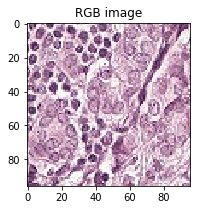

In [7]:
#create dataset objects to controll the data in the generator
training_dataset = DataSet(train_dir_x, train_dir_y, use_percentage=1.0)
validation_dataset = DataSet(valid_dir_x, valid_dir_y, use_percentage=1.0)
test_dataset = DataSet(test_dir_x, use_percentage=1.0)

learned_dataset = DataSet(learned_dir_x, learned_dir_y, use_percentage=1.0)
not_learned_dataset = DataSet(not_learned_dir_x, not_learned_dir_y, use_percentage=1.0)


print(training_dataset.get_lenght())
training_dataset.show_image(1)

In [8]:
#test batch creator
augmentation_perc = 0.5
augmentor = Augmentor(augmentation_perc)
batch_creator = BatchCreator(training_dataset, 
                             augmentor,
                            learned_dataset = learned_dataset, 
                             not_learned_dataset = not_learned_dataset,
                            l_per = 0.5)

x, y = batch_creator.create_batch_learned(64)
print(x.shape)
print(y.shape)
print(augmentor.perc)

(64, 96, 96, 3)
(64, 2)
0.5


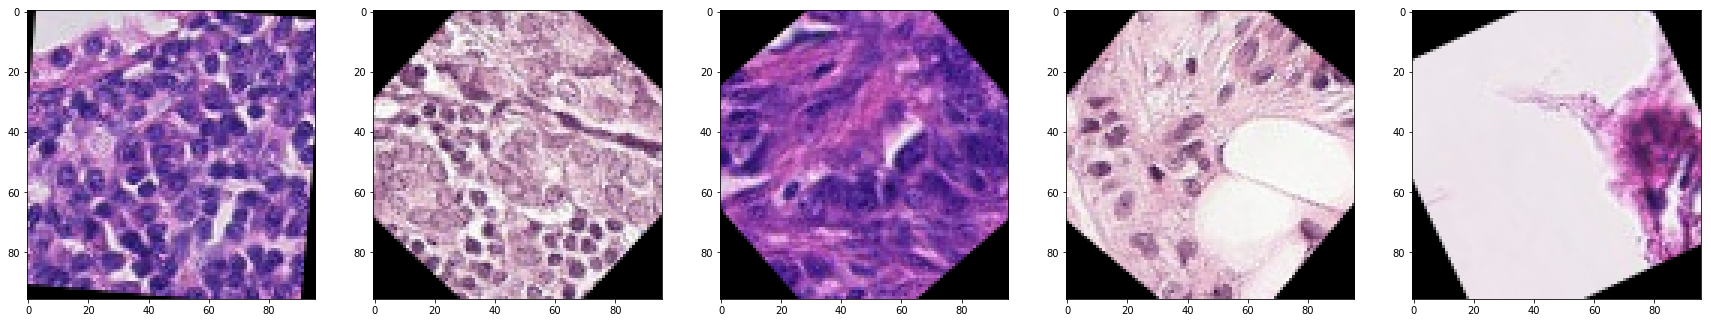

In [9]:
for i in range (5):
    plt.rcParams['figure.figsize'] = (30,30)
    plt.subplot(1,5,i+1)
    plt.imshow(x[i])

In [10]:
batch_creator.index = [0,3]
x2, y2 = batch_creator.create_batch(5)
print(x.shape)
print(y.shape)

(64, 96, 96, 3)
(64, 2)


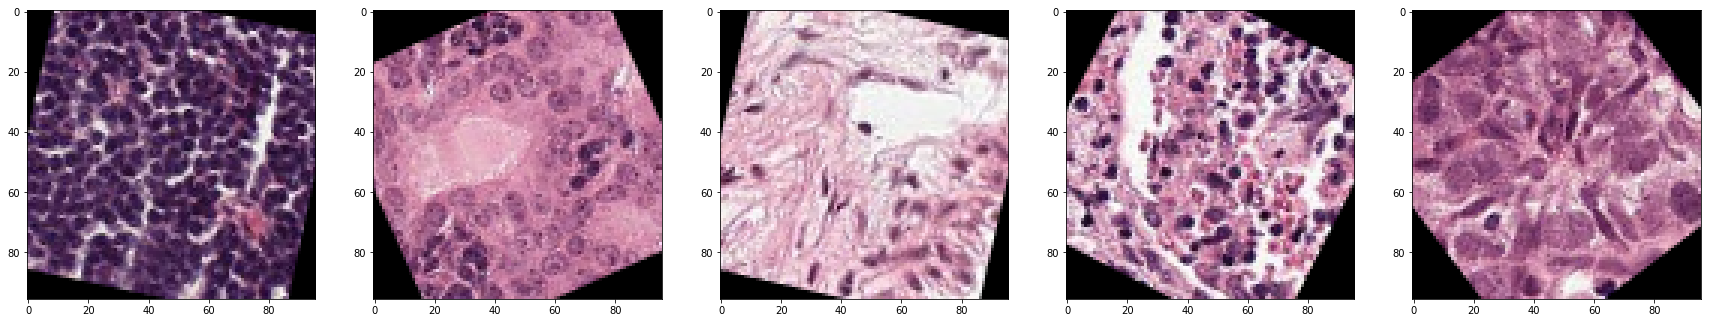

In [11]:
for i in range (5):
    plt.rcParams['figure.figsize'] = (30,30)
    plt.subplot(1,5,i+1)
    plt.imshow(x2[i])

# Create Model


In [14]:
in_t = Input(shape=(96, 96, 3))
#model = createResNet50(in_t, True)
model = createResNet50Top(in_t, True)
#model = CreateKaggleModel(True)

/home/paul/programs/anaconda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/home/paul/git/Ismi19/create_model.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  ResNet_new = Model(input=in_t, output=x_out)


# Train Model

In [15]:
def train_model(model, training_params):
    
    batch_size = training_params['batch_size']
    loss = training_params['loss']
    metrics = training_params['metrics']
    epochs = training_params['epochs']
    steps_per_epoch = training_params['steps_per_epoch']
    optimizer = training_params['optimizer']
    training_dataset = training_params['training_dataset']
    validation_dataset = training_params['validation_dataset']
    
    
    saving_dir = training_params['saving_dir']
    model_name = training_params['model_name']
    sampling_threshold = training_params['sampling_threshold']
    use_sampling_strategy = training_params['use_sampling_strategy']
    augmentor = training_params['augmentor'] 
    learned_dataset = training_params['learned_dataset']
    not_learned_dataset = training_params['not_learned_dataset']
    l_per = training_params['l_per']
    
    log_dir = "./logs/"
    if(not os.path.exists(log_dir)):
        os.mkdir(log_dir)
        
    # batch generator 
    batch_creator = BatchCreator(training_dataset,
                                 augmentor = augmentor,
                                 learned_dataset = learned_dataset, 
                                 not_learned_dataset = not_learned_dataset,
                                 l_per = 0.5)
    
    batch_generator = batch_creator.get_generator(batch_size)
    
    if use_sampling_strategy == 1:
        print('using sampling generator')
        batch_generator = batch_creator.get_sampling_generator(batch_size)
    if use_sampling_strategy == 2:
        print('using learned generator')
        batch_generator = batch_creator.get_learned_generator(batch_size)
        
    # create logger
    logger = Logger(validation_dataset, saving_dir, model_name, batch_creator, sampling_threshold, use_sampling_strategy)

    # compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # train the model
    model.fit_generator(generator=batch_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=epochs,
                        callbacks=[logger],
                        verbose = 1)

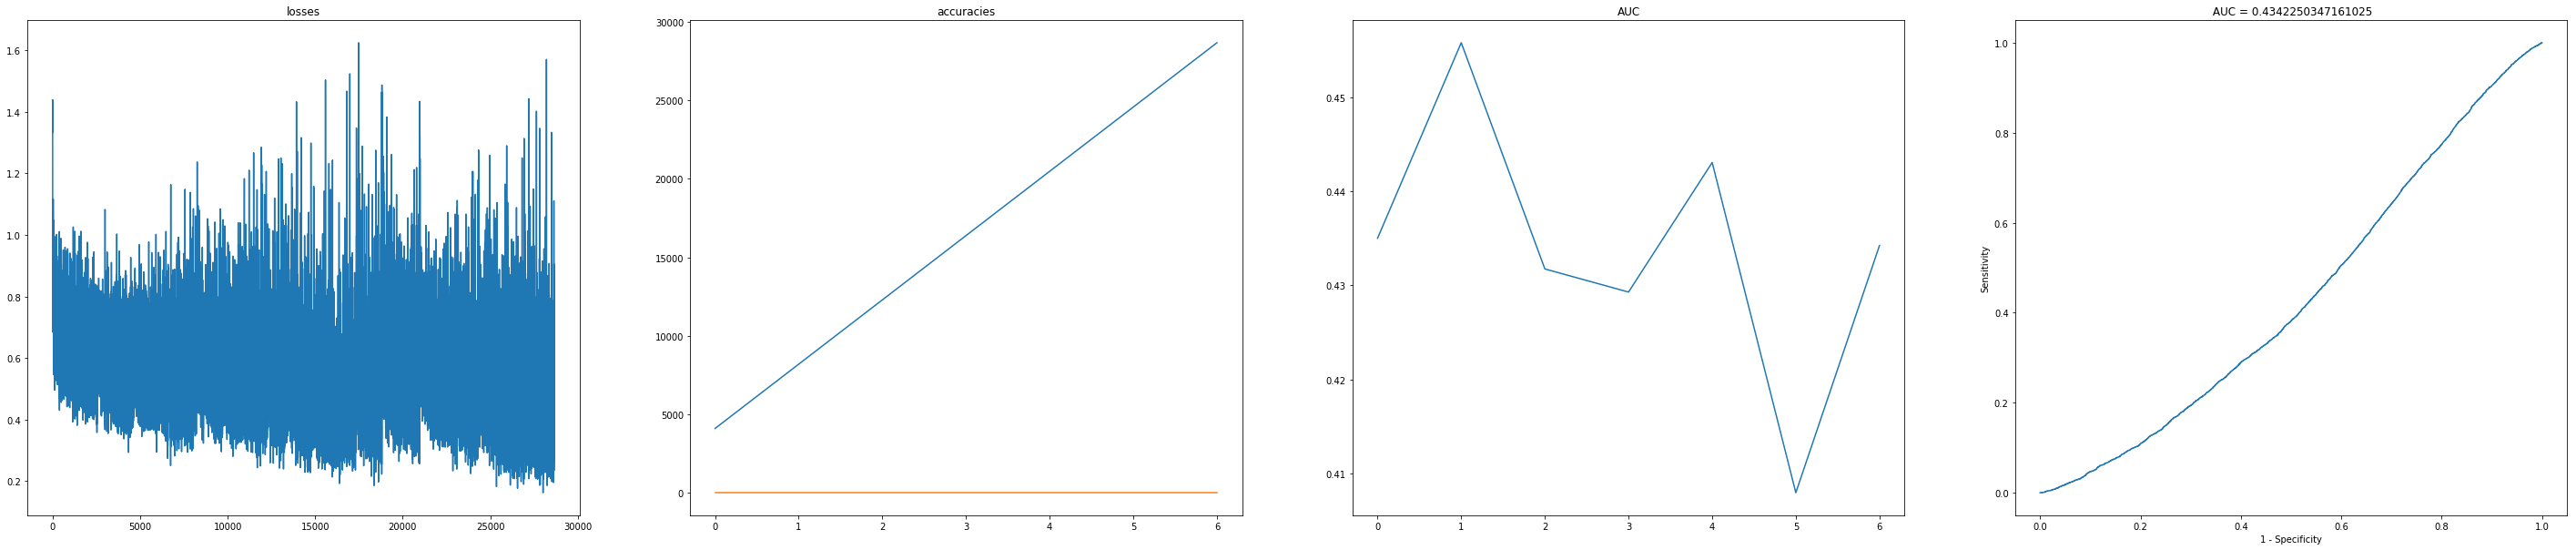

Epoch 8/15
4008/4096 [============================>.] - ETA: 20s - loss: 0.4971 - acc: 0.7757

KeyboardInterrupt: 

In [16]:
# training parameters
saving_dir = './models/'
if(not os.path.exists(saving_dir)):
    os.mkdir(saving_dir)

model_name = 'res_learned_15_epochs'
training_params = {}
training_params['learning_rate'] = 0.002
training_params['batch_size'] = 64 # number of patches in a mini-batch
training_params['steps_per_epoch'] = int(float(training_dataset.get_lenght())/training_params['batch_size']) # number of iterations per epoch
training_params['epochs'] = 15 # number of epochs

training_params['optimizer'] = Adam(lr = training_params['learning_rate'])
training_params['loss'] = ['binary_crossentropy']
training_params['metrics'] = ['accuracy']
training_params['training_dataset'] = training_dataset
training_params['validation_dataset'] = validation_dataset

training_params['saving_dir'] = saving_dir
training_params['model_name'] = model_name

augmentation_perc = 0.8
augmentor = Augmentor(augmentation_perc)
training_params['augmentor'] = augmentor
training_params['learned_dataset'] = learned_dataset
training_params['not_learned_dataset'] = not_learned_dataset
training_params['l_per'] = 0.70 # 0.89 is normal distribution

training_params['use_sampling_strategy'] = 2
training_params['sampling_threshold'] = 0.75

# train model
train_model(model, training_params)

In [17]:
#save model to continue training later with latest model
model_filename = os.path.join(saving_dir, model_name + '_continue.h5')
model.save(model_filename) # save best model to disk

# Test model

In [19]:
# load the best model
#model = createResNet50(in_t, True)
#model = CreateKaggleModel(True)
model = createResNet50Top(in_t, True)
model_path = os.path.join(saving_dir, model_name+'.h5')
model.load_weights(model_path)

/home/paul/programs/anaconda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/paul/git/Ismi19/create_model.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  ResNet_new = Model(input=in_t, output=x_out)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [20]:
#get traing data set
x_test = test_dataset.get_data()
print(test_dataset.get_lenght())
print(x_test.shape)

32768
(32768, 96, 96, 3)


In [21]:
#make predictions
predictions = model.predict(x_test, verbose = 1)
print(predictions.shape)

32768/32768 [==============================] - 96s 3ms/step
(32768, 2)


In [22]:
#We only need the second column because it holds the prediction of being cancer
pred_cancer = predictions[:,1]
#cases an array holding the index
cases = np.arange(test_dataset.get_lenght())

# Make submission

In [23]:
pd_columns = ['case', 'prediction']
df = pd.DataFrame(columns = pd_columns)
df['case']       = cases
df['prediction']       = pred_cancer

submission_dir = "./submissions/"
if(not os.path.exists(submission_dir)):
    os.mkdir(submission_dir)

df.to_csv(os.path.join(submission_dir,'submit_'+model_name+'.csv'), index=False)  

In [ ]:
#

In [ ]:
#

In [ ]:
#